# Part I: Preprocessing

## Basic settings

In [343]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [344]:
import os
import sys
import warnings
from datetime import datetime, timedelta

import matplotlib
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns

warnings.filterwarnings("ignore")
pd.options.display.max_rows = 50
pd.options.display.max_columns = None

In [345]:
src_path = os.path.abspath(os.path.join("../..", "src"))
if src_path not in sys.path:
    sys.path.append(src_path)

In [346]:
from data_generator.data_generator import check_missing_values
from utils.plots import plot_sales, plot_weather_boxplots
from utils.utils import correct_outliers, fill_missing_values,fill_missing_values_grouped, get_sample_stores, analyze_product_distribution, correct_weather_outliers

In [347]:
DATA_DIR = "../../data/"

## Load data

In [348]:
# Load datasets
df_sales_train = pd.read_csv(os.path.join(DATA_DIR, "data_raw/train.csv"))
df_sales_test = pd.read_csv(os.path.join(DATA_DIR, "data_raw/test.csv"))
df_weather = pd.read_csv(os.path.join(DATA_DIR, "data_raw/weather.csv"))
df_key = pd.read_csv(os.path.join(DATA_DIR, "data_raw/key.csv"))

## Clean sales data 

In [349]:
# Combine sales data
df_sales = pd.concat([df_sales_train], ignore_index=True)
df_sales = df_sales.sort_values(['store_nbr', 'item_nbr', 'date'])

# Convert date columns to datetime
df_sales["date"] = pd.to_datetime(df_sales["date"])
df_weather["date"] = pd.to_datetime(df_weather["date"])

### Handling missing values

In [350]:
# Check missing values for weather data
display(check_missing_values(df_weather))

,counts,ratio (%)
station_nbr,0,0.0
date,0,0.0
tmax,0,0.0
tmin,0,0.0
tavg,0,0.0
depart,0,0.0
dewpoint,0,0.0
wetbulb,0,0.0
heat,0,0.0
cool,0,0.0


In [351]:
# Check missing values for sales data
display(check_missing_values(df_sales))

,counts,ratio (%)
date,0,0.0
store_nbr,0,0.0
item_nbr,0,0.0
units,0,0.0


###  Data Filtering: Remove Non-Selling Products
This step identifies and filters out store-item combinations with zero total sales. 
Not all stores carry all products, keeping zero-sale combinations introduces noise 
and reduces model accuracy.

**Approach:**
- Calculate total sales per store-item pair
- Create whitelist of valid combinations (total sales > 0)
- Apply inner join to retain only valid pairs

**Expected outcome:** Reduced dataset size while maintaining all meaningful sales data.


🔍 ANALYZING PRODUCT DISTRIBUTION...

✅ Found 255 valid (Store, Item) pairs with sales > 0


TOP 15 MOST WIDELY SOLD PRODUCTS
 item_nbr  num_stores
       93          29
        5          18
        9          17
       45          16
       16           8
       86           7
      105           6
       37           6
       15           5
       44           5
       50           5
       68           5
      104           4
       51           4
       61           3



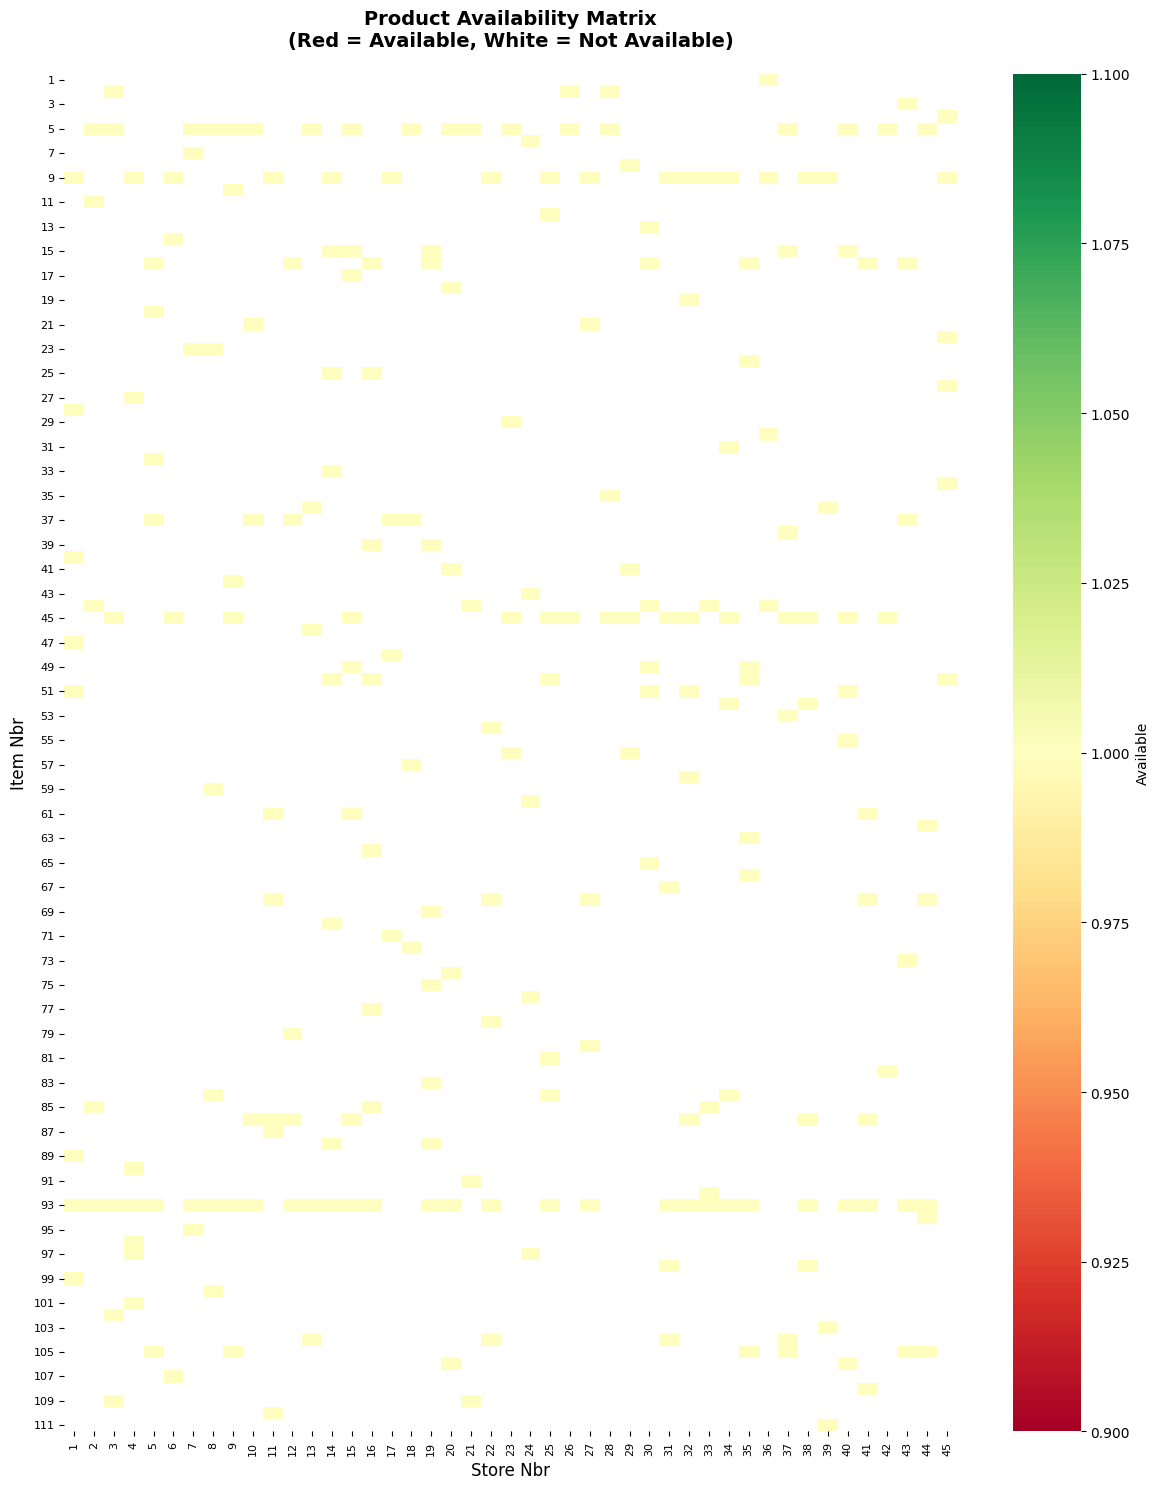


SUMMARY: Product Distribution Analysis
Total Stores: 45
Total Items: 111
Total Possible Combinations: 4,995
Actual Products Sold: 255
Coverage: 5.1%

Original rows: 4,617,600
Filtered rows: 236,038
Reduction: 94.9%


In [352]:
# Analyze product distribution across stores
retailed_items = analyze_product_distribution(
    df=df_sales,
    store_col='store_nbr',
    item_col='item_nbr',
    value_col='units',
    show_heatmap=True,
    show_top=True,
    top_n=15
)

# Filter dataset: Keep only store-item pairs with sales > 0
# Inner join retains rows present in BOTH dataframes
df_retailed = df_sales.merge(
    retailed_items, 
    on=['store_nbr', 'item_nbr'], 
    how='inner'
)
df_retailed['logunits'] = np.log1p(df_retailed['units'])

print(f"Original rows: {len(df_sales):,}")
print(f"Filtered rows: {len(df_retailed):,}")
print(f"Reduction: {(1 - len(df_retailed)/len(df_sales))*100:.1f}%")

Con số 5.1% nói lên điều gì?
Nó nói rằng: Trung bình, một cửa hàng chỉ bán khoảng 5-6 món hàng trong danh sách 111 món kia thôi

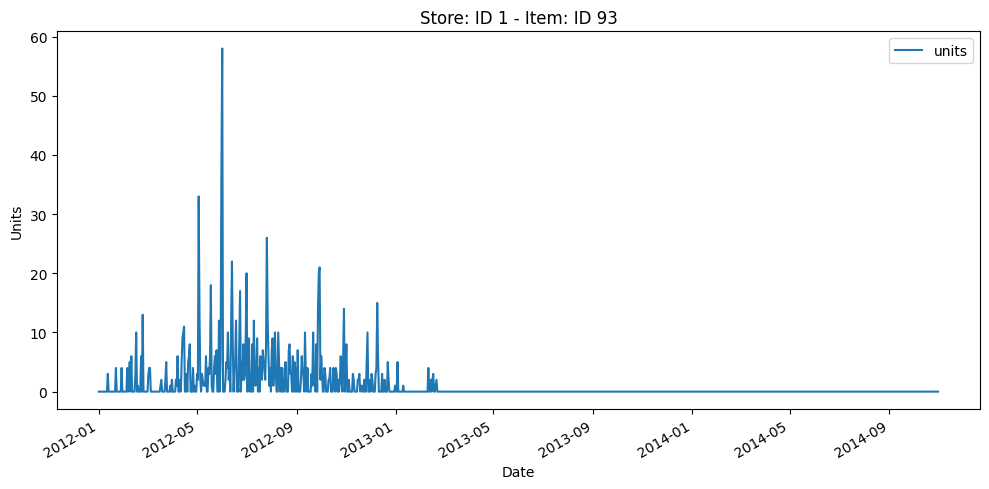

In [353]:
# Checking nan values and outliers in a plot
plot_sales(df_retailed, store_id=1, item_id=93)

In [354]:
# Fill nan using mean values
df_retailed_filled = fill_missing_values_grouped(df_retailed)

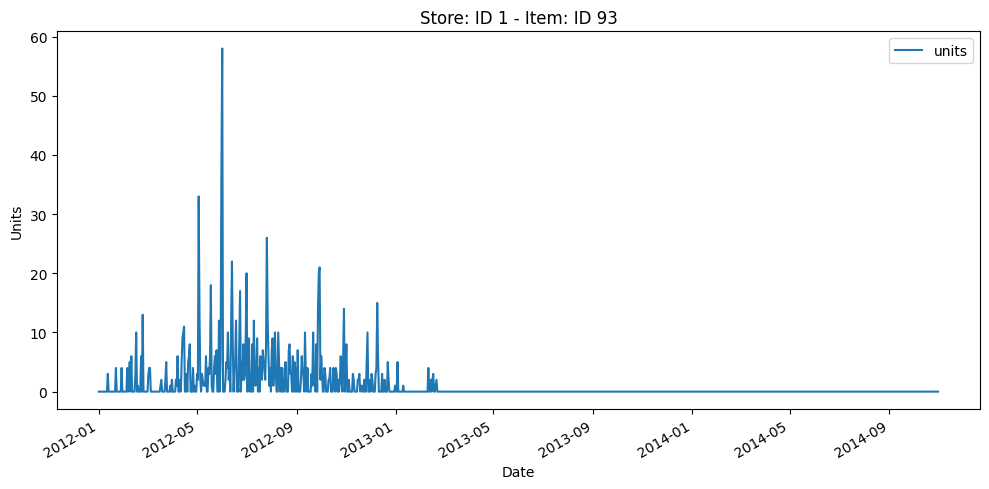

In [355]:
# Checking nan values and outliers in a plot
plot_sales(df_retailed_filled, store_id=1, item_id=93)

In [356]:
# Check missing values
display(check_missing_values(df_retailed_filled))

,counts,ratio (%)
date,0,0.0
store_nbr,0,0.0
item_nbr,0,0.0
units,0,0.0
logunits,0,0.0


### Check and correct outliers

In [357]:
df_retailed_filled

,date,store_nbr,item_nbr,units,logunits
0,2012-01-01,1,9,29,3.401197
1,2012-01-02,1,9,60,4.110874
2,2012-01-03,1,9,15,2.772589
3,2012-01-04,1,9,20,3.044522
4,2012-01-05,1,9,16,2.833213
...,...,...,...,...,...
236033,2014-10-27,45,50,0,0.000000
236034,2014-10-28,45,50,1,0.693147
236035,2014-10-29,45,50,0,0.000000
236036,2014-10-30,45,50,0,0.000000


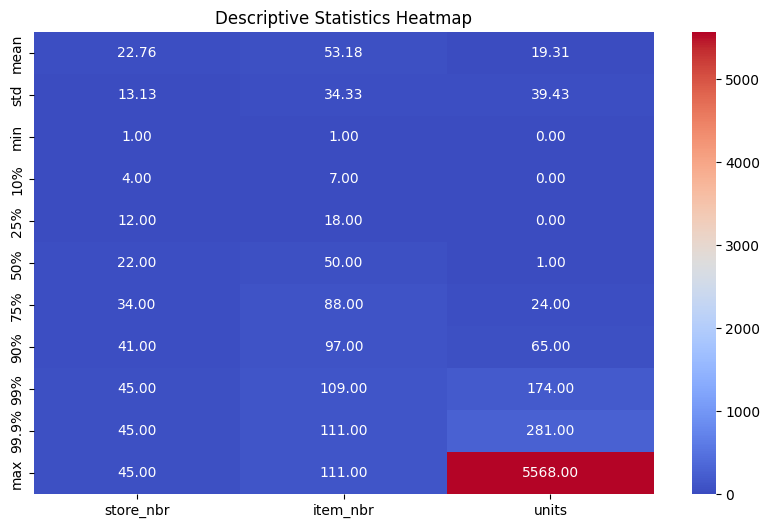

In [358]:
# Using heat map to visualize outliers
summary = (
    df_retailed_filled[["store_nbr", "item_nbr", "units"]] 
    .describe(percentiles=[0.1, 0.25, 0.5, 0.75, 0.9, 0.99, 0.999])
    .iloc[1:]
)

plt.figure(figsize=(10, 6))
sns.heatmap(summary, cmap="coolwarm", annot=True, fmt=".2f")
plt.title("Descriptive Statistics Heatmap")
plt.show()

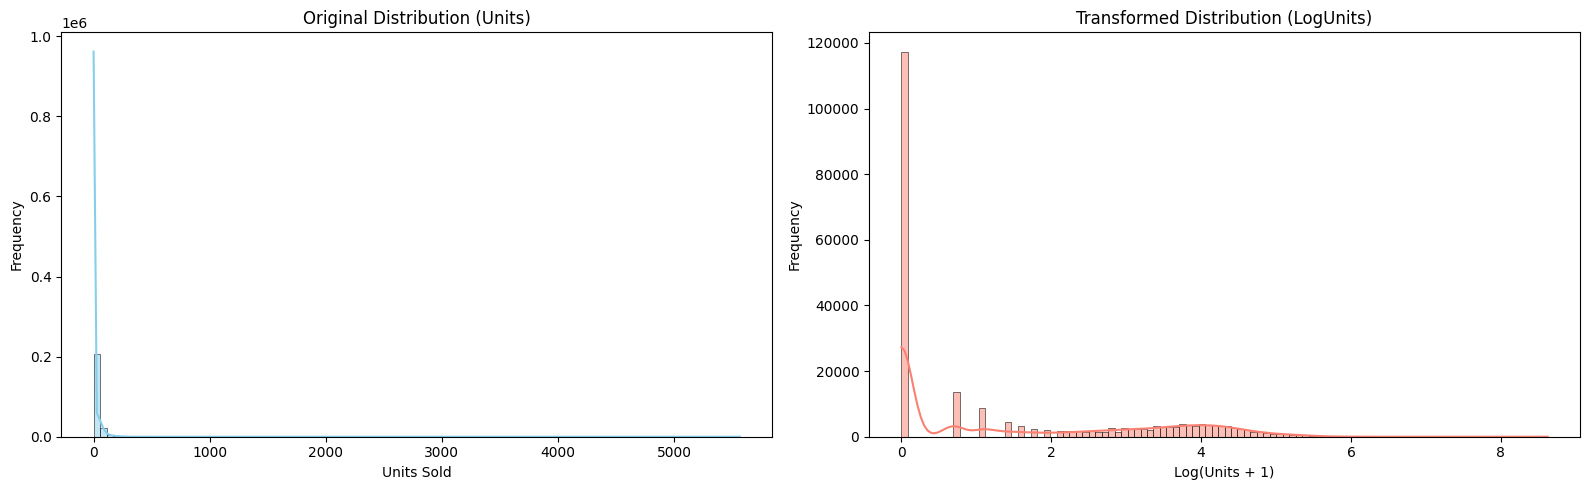

In [359]:
# --- SO SÁNH TRỰC QUAN: TRƯỚC VÀ SAU KHI LOG ---
fig, axes = plt.subplots(1, 2, figsize=(16, 5))

# 1. Biểu đồ gốc (Units) - Bị lệch trái, đuôi dài
sns.histplot(df_retailed_filled["units"], bins=100, kde=True, ax=axes[0], color='skyblue')
axes[0].set_title("Original Distribution (Units)")
axes[0].set_xlabel("Units Sold")
axes[0].set_ylabel("Frequency")

# 2. Biểu đồ Log (LogUnits) - Phân phối chuẩn đẹp hơn
sns.histplot(df_retailed_filled["logunits"], bins=100, kde=True, ax=axes[1], color='salmon')
axes[1].set_title("Transformed Distribution (LogUnits)")
axes[1].set_xlabel("Log(Units + 1)")
axes[1].set_ylabel("Frequency")

plt.tight_layout()
plt.show()


In [360]:
# Correct outliers
df_sales_corrected = correct_outliers(df=df_retailed_filled)

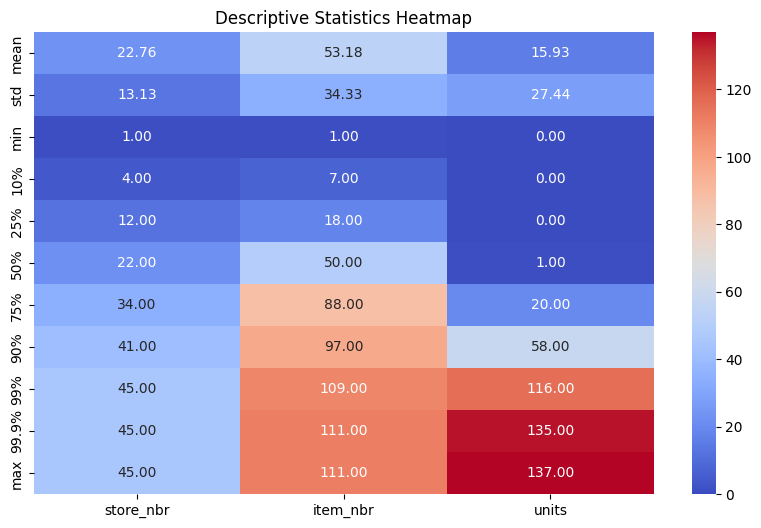

In [361]:
# Check if outliers were corrected properly
summary = (
    df_sales_corrected[["store_nbr", "item_nbr", "units"]] 
    .describe(percentiles=[0.1, 0.25, 0.5, 0.75, 0.9, 0.99, 0.999])
    .iloc[1:]
)

plt.figure(figsize=(10, 6))
sns.heatmap(summary, cmap="coolwarm", annot=True, fmt=".2f")
plt.title("Descriptive Statistics Heatmap")
plt.show()

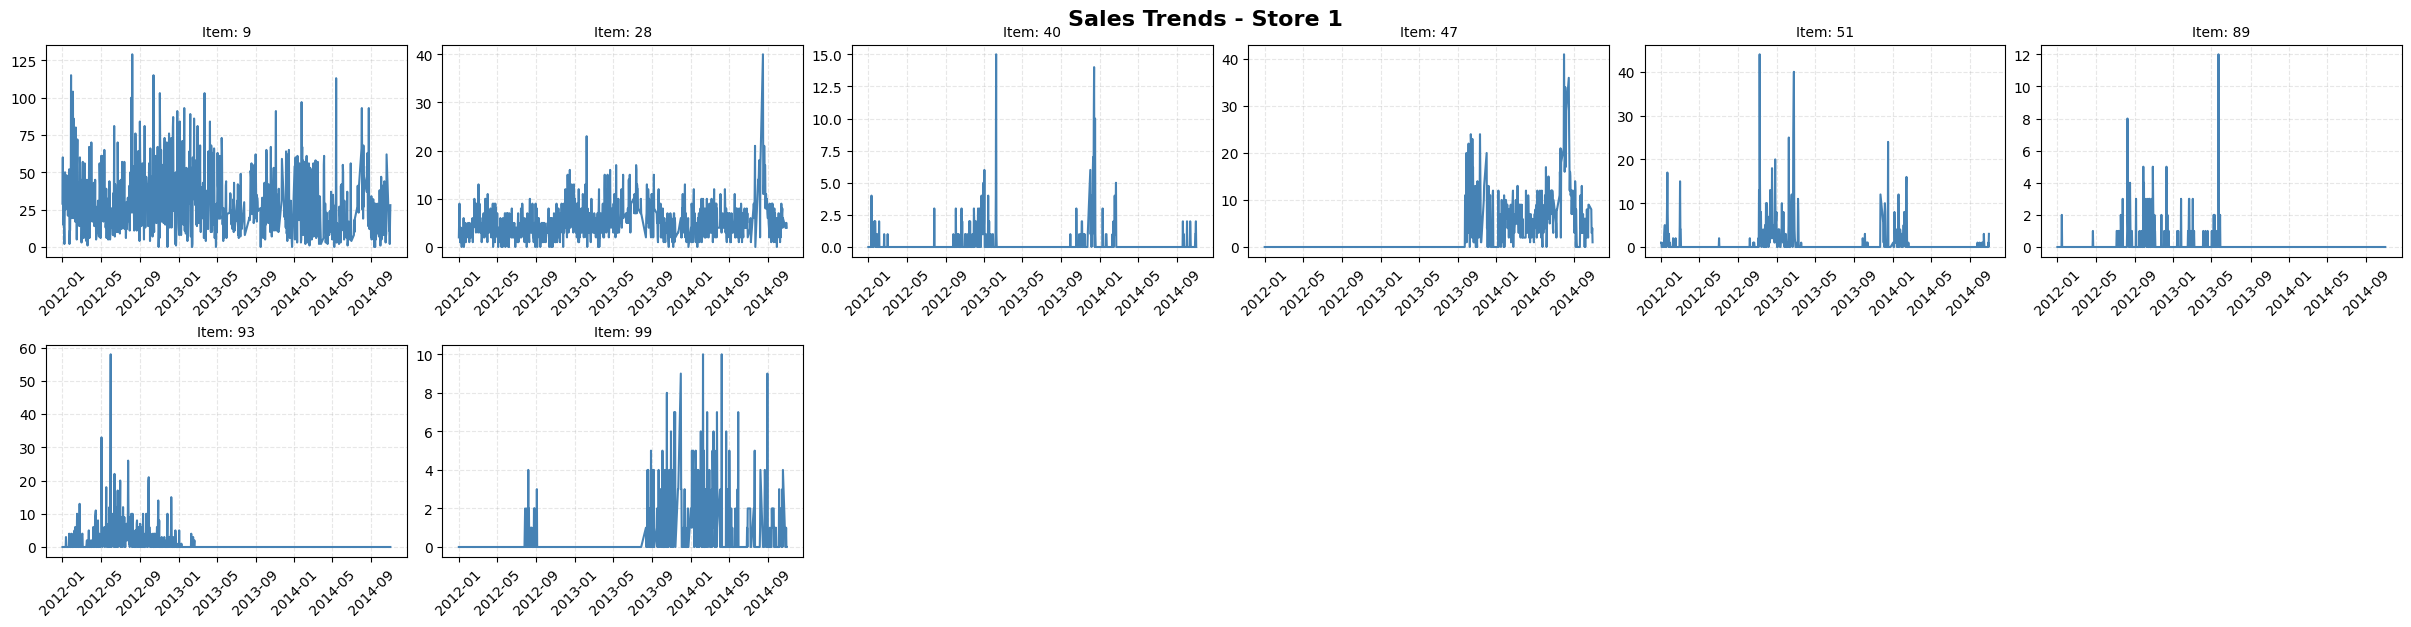

In [362]:
import math

# 1. Lấy dữ liệu Store mục tiêu
store_nbr = 1
# Filter trực tiếp thay vì gọi hàm get_sample_stores (để code ngắn gọn hơn)
df_sample_store = df_sales_corrected[df_sales_corrected["store_nbr"] == store_nbr]

# 2. Lấy danh sách Items (chỉ những item có trong dataset đã filter)
lst_items = df_sample_store["item_nbr"].unique().tolist()

# 3. Tính toán Layout Grid động (Clean Code)
ncols = 6
nrows = math.ceil(len(lst_items) / ncols)

fig, axes = plt.subplots(
    nrows, ncols, figsize=(ncols * 4, nrows * 3), constrained_layout=True
)
axes = axes.flatten()

# 4. Vẽ biểu đồ
for idx, item_nbr in enumerate(lst_items):
    ax = axes[idx]
    df2plot = df_sample_store[df_sample_store["item_nbr"] == item_nbr]
    
    # Vẽ đường sales (units)
    ax.plot(df2plot["date"], df2plot["units"], color="steelblue", linewidth=1.5)
    
    ax.set_title(f"Item: {item_nbr}", fontsize=10)
    ax.set_xlabel("")
    ax.set_ylabel("")
    ax.tick_params(axis="x", rotation=45)
    ax.grid(True, linestyle="--", alpha=0.3)

# 5. Ẩn các subplots thừa
for ax in axes[len(lst_items):]:
    ax.axis("off")

# Main title
fig.suptitle(f"Sales Trends - Store {store_nbr}", fontsize=16, fontweight="bold", y=1.02)
plt.show()


In [363]:
check_missing_values(df_sales_corrected)

,counts,ratio (%)
date,0,0.0
store_nbr,0,0.0
item_nbr,0,0.0
units,0,0.0
logunits,0,0.0


## Clean Weather data

In [364]:
df_weather.head()

,station_nbr,date,tmax,tmin,tavg,depart,dewpoint,wetbulb,heat,cool,sunrise,sunset,codesum,snowfall,preciptotal,stnpressure,sealevel,resultspeed,resultdir,avgspeed
0,1,2012-01-01,52,31,42,M,36,40,23,0,-,-,RA FZFG BR,M,0.05,29.78,29.92,3.6,20,4.6
1,2,2012-01-01,48,33,41,16,37,39,24,0,0716,1626,RA,0.0,0.07,28.82,29.91,9.1,23,11.3
2,3,2012-01-01,55,34,45,9,24,36,20,0,0735,1720,,0.0,0.00,29.77,30.47,9.9,31,10.0
3,4,2012-01-01,63,47,55,4,28,43,10,0,0728,1742,,0.0,0.00,29.79,30.48,8.0,35,8.2
4,6,2012-01-01,63,34,49,0,31,43,16,0,0727,1742,,0.0,0.00,29.95,30.47,14.0,36,13.8


In [365]:
df_weather.shape

(20517, 20)

In [366]:
df_weather.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20517 entries, 0 to 20516
Data columns (total 20 columns):
 #   Column       Non-Null Count  Dtype         
---  ------       --------------  -----         
 0   station_nbr  20517 non-null  int64         
 1   date         20517 non-null  datetime64[ns]
 2   tmax         20517 non-null  object        
 3   tmin         20517 non-null  object        
 4   tavg         20517 non-null  object        
 5   depart       20517 non-null  object        
 6   dewpoint     20517 non-null  object        
 7   wetbulb      20517 non-null  object        
 8   heat         20517 non-null  object        
 9   cool         20517 non-null  object        
 10  sunrise      20517 non-null  object        
 11  sunset       20517 non-null  object        
 12  codesum      20517 non-null  object        
 13  snowfall     20517 non-null  object        
 14  preciptotal  20517 non-null  object        
 15  stnpressure  20517 non-null  object        
 16  seal

In [367]:
df_codesum = df_weather["codesum"].str.get_dummies(sep=' ')
df_weather_processed = df_weather.drop("codesum", axis=1).join(df_codesum)

df_weather_processed.head()


,station_nbr,date,tmax,tmin,tavg,depart,dewpoint,wetbulb,heat,cool,sunrise,sunset,snowfall,preciptotal,stnpressure,sealevel,resultspeed,resultdir,avgspeed,BCFG,BLDU,BLSN,BR,DU,DZ,FG,FG+,FU,FZDZ,FZFG,FZRA,GR,GS,HZ,MIFG,PL,PRFG,RA,SG,SN,SQ,TS,TSRA,TSSN,UP,VCFG,VCTS
0,1,2012-01-01,52,31,42,M,36,40,23,0,-,-,M,0.05,29.78,29.92,3.6,20,4.6,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0
1,2,2012-01-01,48,33,41,16,37,39,24,0,0716,1626,0.0,0.07,28.82,29.91,9.1,23,11.3,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0
2,3,2012-01-01,55,34,45,9,24,36,20,0,0735,1720,0.0,0.00,29.77,30.47,9.9,31,10.0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3,4,2012-01-01,63,47,55,4,28,43,10,0,0728,1742,0.0,0.00,29.79,30.48,8.0,35,8.2,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
4,6,2012-01-01,63,34,49,0,31,43,16,0,0727,1742,0.0,0.00,29.95,30.47,14.0,36,13.8,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


errors='coerce': Lệnh này sẽ biến bất kỳ ký tự lạ nào còn sót lại (mà bạn chưa phát hiện ra) thành NaN luôn

In [369]:
# 1. Thay thế các ký tự đặc biệt
replace_dict = {
    "M": np.nan,  # Missing -> NaN
    "-": np.nan,  # Missing -> NaN
    "T": 0.01     # Trace -> Lượng nhỏ (ví dụ 0.01 inch)
}

col_list = ['tmax', 'tmin', 'tavg', 'depart', 'dewpoint', 'wetbulb', 'heat', 'cool', 'sunrise', 'sunset', 'snowfall', 'preciptotal', 'stnpressure']

# Áp dụng replace
df_weather_processed[col_list] = df_weather_processed[col_list].replace(replace_dict)

# 2. Ép kiểu về số (Numeric)
# Sau khi replace, dữ liệu vẫn có thể đang ở dạng object/string, cần chuyển về float
for col in col_list:
    df_weather_processed[col] = pd.to_numeric(df_weather_processed[col], errors='coerce')

# Kiểm tra lại
df_weather_processed[col_list].head()

,tmax,tmin,tavg,depart,dewpoint,wetbulb,heat,cool,sunrise,sunset,snowfall,preciptotal,stnpressure
0,52.0,31.0,42.0,NaN,36.0,40.0,23.0,0.0,NaN,NaN,NaN,0.05,29.78
1,48.0,33.0,41.0,16.0,37.0,39.0,24.0,0.0,716.0,1626.0,0.0,0.07,28.82
2,55.0,34.0,45.0,9.0,24.0,36.0,20.0,0.0,735.0,1720.0,0.0,0.00,29.77
3,63.0,47.0,55.0,4.0,28.0,43.0,10.0,0.0,728.0,1742.0,0.0,0.00,29.79
4,63.0,34.0,49.0,0.0,31.0,43.0,16.0,0.0,727.0,1742.0,0.0,0.00,29.95


In [370]:
df_weather_processed

,station_nbr,date,tmax,tmin,tavg,depart,dewpoint,wetbulb,heat,cool,sunrise,sunset,snowfall,preciptotal,stnpressure,sealevel,resultspeed,resultdir,avgspeed,BCFG,BLDU,BLSN,BR,DU,DZ,FG,FG+,FU,FZDZ,FZFG,FZRA,GR,GS,HZ,MIFG,PL,PRFG,RA,SG,SN,SQ,TS,TSRA,TSSN,UP,VCFG,VCTS
0,1,2012-01-01,52.0,31.0,42.0,NaN,36.0,40.0,23.0,0.0,NaN,NaN,NaN,0.05,29.78,29.92,3.6,20,4.6,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0
1,2,2012-01-01,48.0,33.0,41.0,16.0,37.0,39.0,24.0,0.0,716.0,1626.0,0.0,0.07,28.82,29.91,9.1,23,11.3,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0
2,3,2012-01-01,55.0,34.0,45.0,9.0,24.0,36.0,20.0,0.0,735.0,1720.0,0.0,0.00,29.77,30.47,9.9,31,10.0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3,4,2012-01-01,63.0,47.0,55.0,4.0,28.0,43.0,10.0,0.0,728.0,1742.0,0.0,0.00,29.79,30.48,8.0,35,8.2,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
4,6,2012-01-01,63.0,34.0,49.0,0.0,31.0,43.0,16.0,0.0,727.0,1742.0,0.0,0.00,29.95,30.47,14.0,36,13.8,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
20512,16,2014-10-31,53.0,34.0,44.0,NaN,35.0,41.0,21.0,0.0,NaN,NaN,NaN,0.00,29.90,29.99,4.5,03,5.3,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
20513,17,2014-10-31,59.0,34.0,47.0,NaN,32.0,41.0,18.0,0.0,NaN,NaN,0.0,0.00,29.72,30.39,9.2,01,9.3,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0
20514,18,2014-10-31,67.0,49.0,58.0,-4.0,40.0,50.0,7.0,0.0,644.0,1738.0,0.0,0.00,29.78,30.28,10.6,36,11.2,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
20515,19,2014-10-31,45.0,33.0,39.0,-6.0,24.0,32.0,26.0,0.0,624.0,1646.0,0.1,0.02,29.51,30.24,20.4,34,20.9,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,1,0,0,0,0,0,0,0


change to numeric

In [371]:
exclude_cols = ['station_nbr', 'date']
cols_to_convert = [col for col in df_weather_processed.columns if col not in exclude_cols]
# Apply pd.to_numeric cho các cột đó
df_weather_processed[cols_to_convert] = df_weather_processed[cols_to_convert].apply(pd.to_numeric, errors='coerce')

df_weather_processed.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20517 entries, 0 to 20516
Data columns (total 47 columns):
 #   Column       Non-Null Count  Dtype         
---  ------       --------------  -----         
 0   station_nbr  20517 non-null  int64         
 1   date         20517 non-null  datetime64[ns]
 2   tmax         19611 non-null  float64       
 3   tmin         19609 non-null  float64       
 4   tavg         19048 non-null  float64       
 5   depart       9006 non-null   float64       
 6   dewpoint     19851 non-null  float64       
 7   wetbulb      19265 non-null  float64       
 8   heat         19048 non-null  float64       
 9   cool         19048 non-null  float64       
 10  sunrise      10861 non-null  float64       
 11  sunset       10861 non-null  float64       
 12  snowfall     12982 non-null  float64       
 13  preciptotal  17247 non-null  float64       
 14  stnpressure  19588 non-null  float64       
 15  sealevel     18793 non-null  float64       
 16  resu

In [372]:
df_weather_processed

,station_nbr,date,tmax,tmin,tavg,depart,dewpoint,wetbulb,heat,cool,sunrise,sunset,snowfall,preciptotal,stnpressure,sealevel,resultspeed,resultdir,avgspeed,BCFG,BLDU,BLSN,BR,DU,DZ,FG,FG+,FU,FZDZ,FZFG,FZRA,GR,GS,HZ,MIFG,PL,PRFG,RA,SG,SN,SQ,TS,TSRA,TSSN,UP,VCFG,VCTS
0,1,2012-01-01,52.0,31.0,42.0,NaN,36.0,40.0,23.0,0.0,NaN,NaN,NaN,0.05,29.78,29.92,3.6,20.0,4.6,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0
1,2,2012-01-01,48.0,33.0,41.0,16.0,37.0,39.0,24.0,0.0,716.0,1626.0,0.0,0.07,28.82,29.91,9.1,23.0,11.3,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0
2,3,2012-01-01,55.0,34.0,45.0,9.0,24.0,36.0,20.0,0.0,735.0,1720.0,0.0,0.00,29.77,30.47,9.9,31.0,10.0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3,4,2012-01-01,63.0,47.0,55.0,4.0,28.0,43.0,10.0,0.0,728.0,1742.0,0.0,0.00,29.79,30.48,8.0,35.0,8.2,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
4,6,2012-01-01,63.0,34.0,49.0,0.0,31.0,43.0,16.0,0.0,727.0,1742.0,0.0,0.00,29.95,30.47,14.0,36.0,13.8,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
20512,16,2014-10-31,53.0,34.0,44.0,NaN,35.0,41.0,21.0,0.0,NaN,NaN,NaN,0.00,29.90,29.99,4.5,3.0,5.3,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
20513,17,2014-10-31,59.0,34.0,47.0,NaN,32.0,41.0,18.0,0.0,NaN,NaN,0.0,0.00,29.72,30.39,9.2,1.0,9.3,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0
20514,18,2014-10-31,67.0,49.0,58.0,-4.0,40.0,50.0,7.0,0.0,644.0,1738.0,0.0,0.00,29.78,30.28,10.6,36.0,11.2,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
20515,19,2014-10-31,45.0,33.0,39.0,-6.0,24.0,32.0,26.0,0.0,624.0,1646.0,0.1,0.02,29.51,30.24,20.4,34.0,20.9,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,1,0,0,0,0,0,0,0


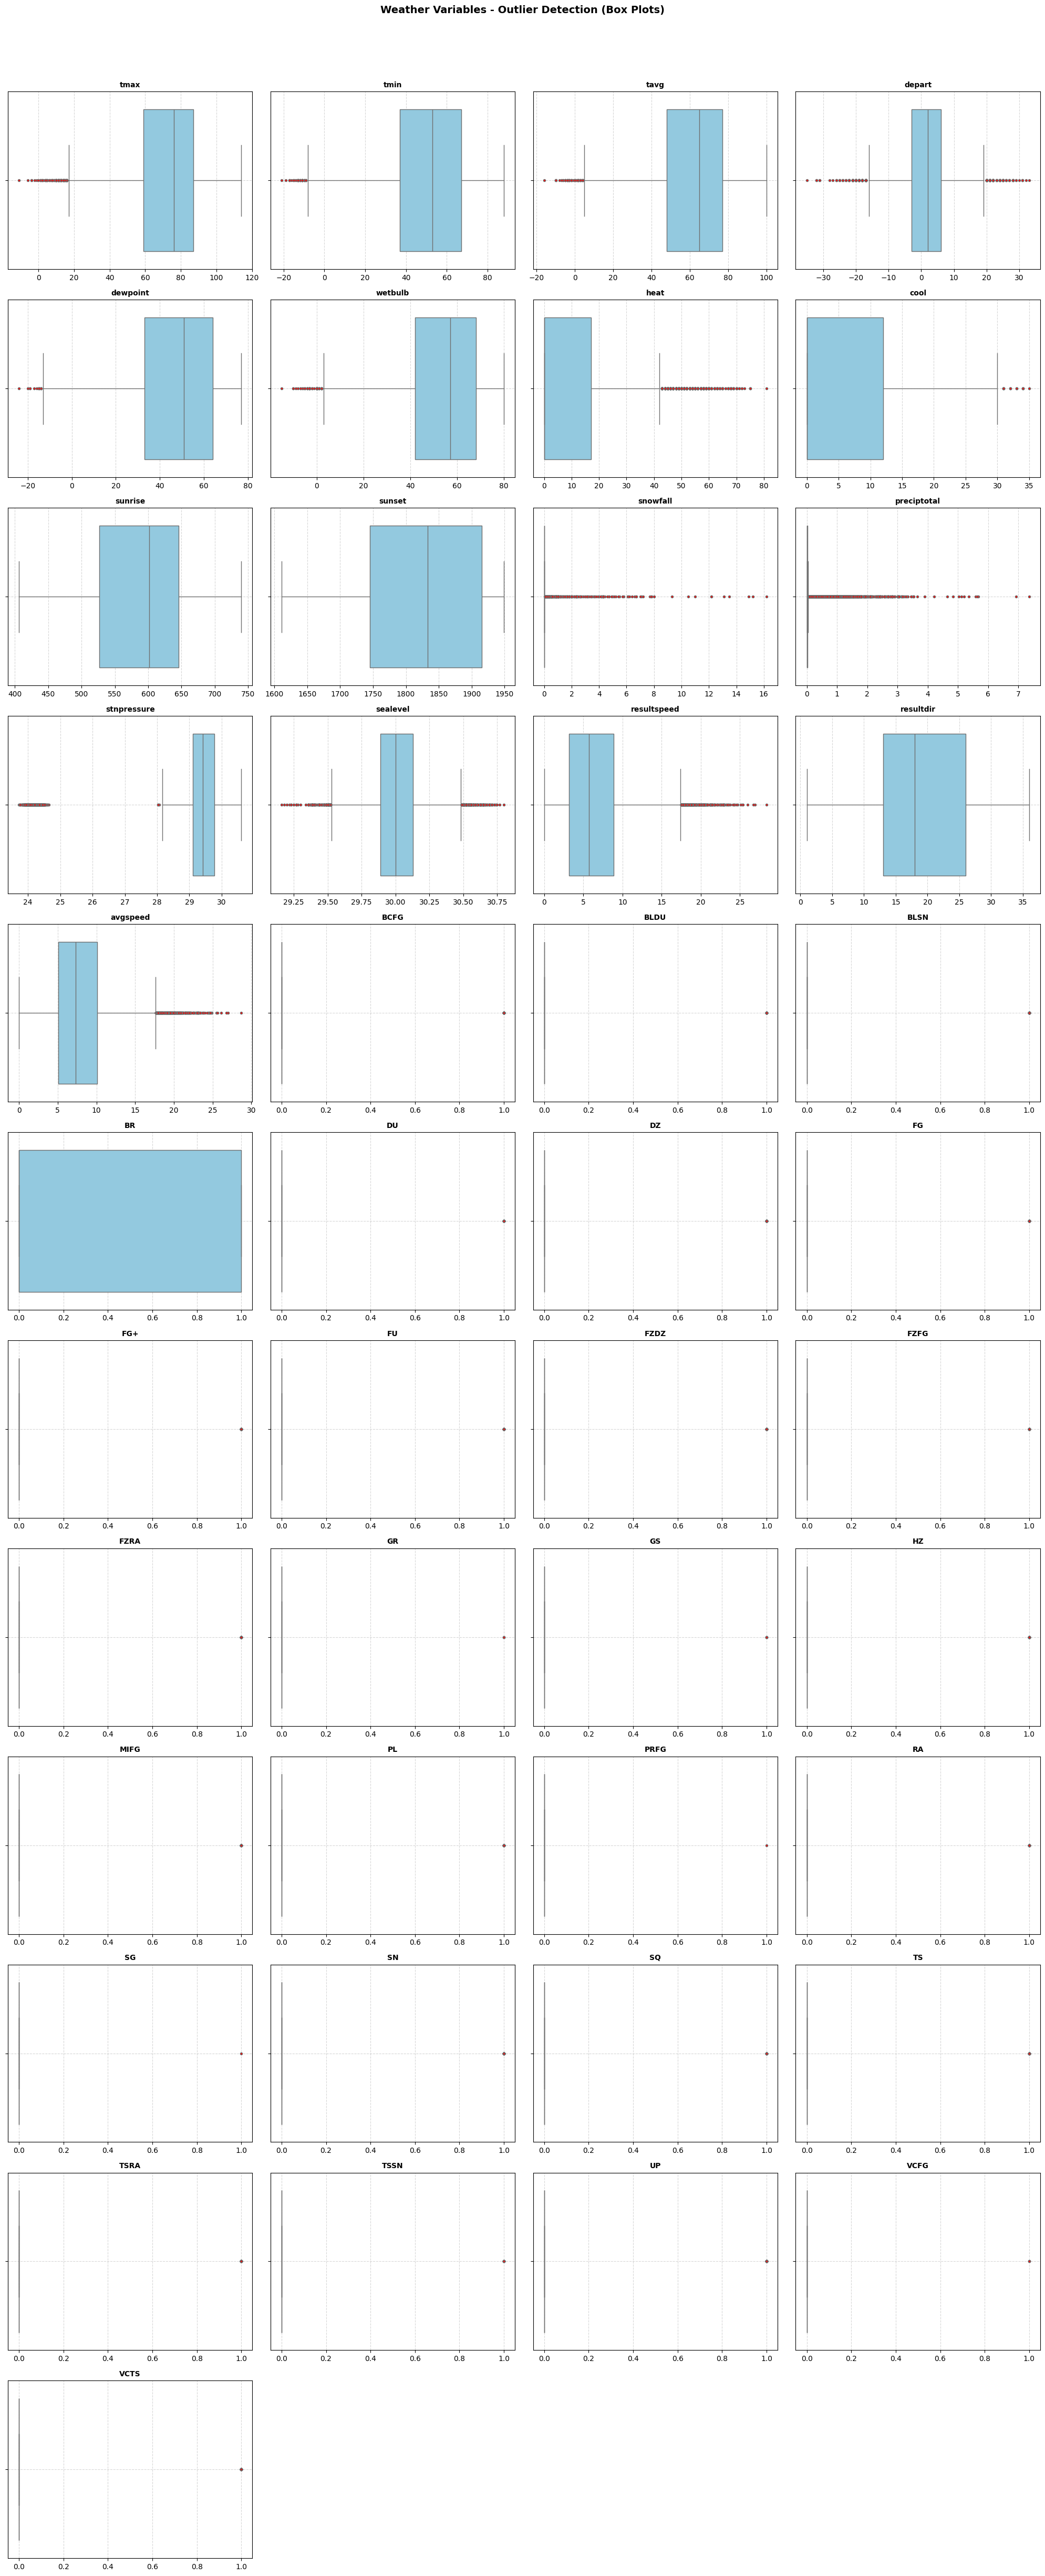

In [374]:
exclude_cols = ['station_nbr', 'date']
weather_cols = [col for col in df_weather_processed.columns if col not in exclude_cols]

plot_weather_boxplots(df_weather_processed, weather_cols, ncols=4)

KHÔNG NÊN áp dụng IQR outlier removal cho các biến thưa thớt (Sparse) như snowfall, preciptotal.
Không áp dụng lên one-hot

In [ ]:
cols_to_fix_outliers = [
    'tmax', 'tmin', 'tavg', 'depart', 'dewpoint', 'wetbulb', 
    'heat', 'cool', 'sunrise', 'sunset', 'stnpressure', 
    'sealevel', 'resultspeed', 'resultdir', 'avgspeed'
]

valid_cols = [col for col in cols_to_fix_outliers if col in df_weather_processed.columns]

# Chạy hàm
df_weather_processed = correct_weather_outliers(df_weather_processed, valid_cols, method='iqr', factor=3)

Column 'BCFG': Found 111 outliers. Range allowed: [0.00, 0.00]
Column 'BLDU': Found 14 outliers. Range allowed: [0.00, 0.00]
Column 'BLSN': Found 46 outliers. Range allowed: [0.00, 0.00]
Column 'DU': Found 14 outliers. Range allowed: [0.00, 0.00]
Column 'DZ': Found 475 outliers. Range allowed: [0.00, 0.00]
Column 'FG': Found 606 outliers. Range allowed: [0.00, 0.00]
Column 'FG+': Found 837 outliers. Range allowed: [0.00, 0.00]
Column 'FU': Found 33 outliers. Range allowed: [0.00, 0.00]
Column 'FZDZ': Found 33 outliers. Range allowed: [0.00, 0.00]
Column 'FZFG': Found 210 outliers. Range allowed: [0.00, 0.00]
Column 'FZRA': Found 125 outliers. Range allowed: [0.00, 0.00]
Column 'GR': Found 3 outliers. Range allowed: [0.00, 0.00]
Column 'GS': Found 5 outliers. Range allowed: [0.00, 0.00]
Column 'HZ': Found 1482 outliers. Range allowed: [0.00, 0.00]
Column 'MIFG': Found 52 outliers. Range allowed: [0.00, 0.00]
Column 'PL': Found 20 outliers. Range allowed: [0.00, 0.00]
Column 'PRFG': Foun

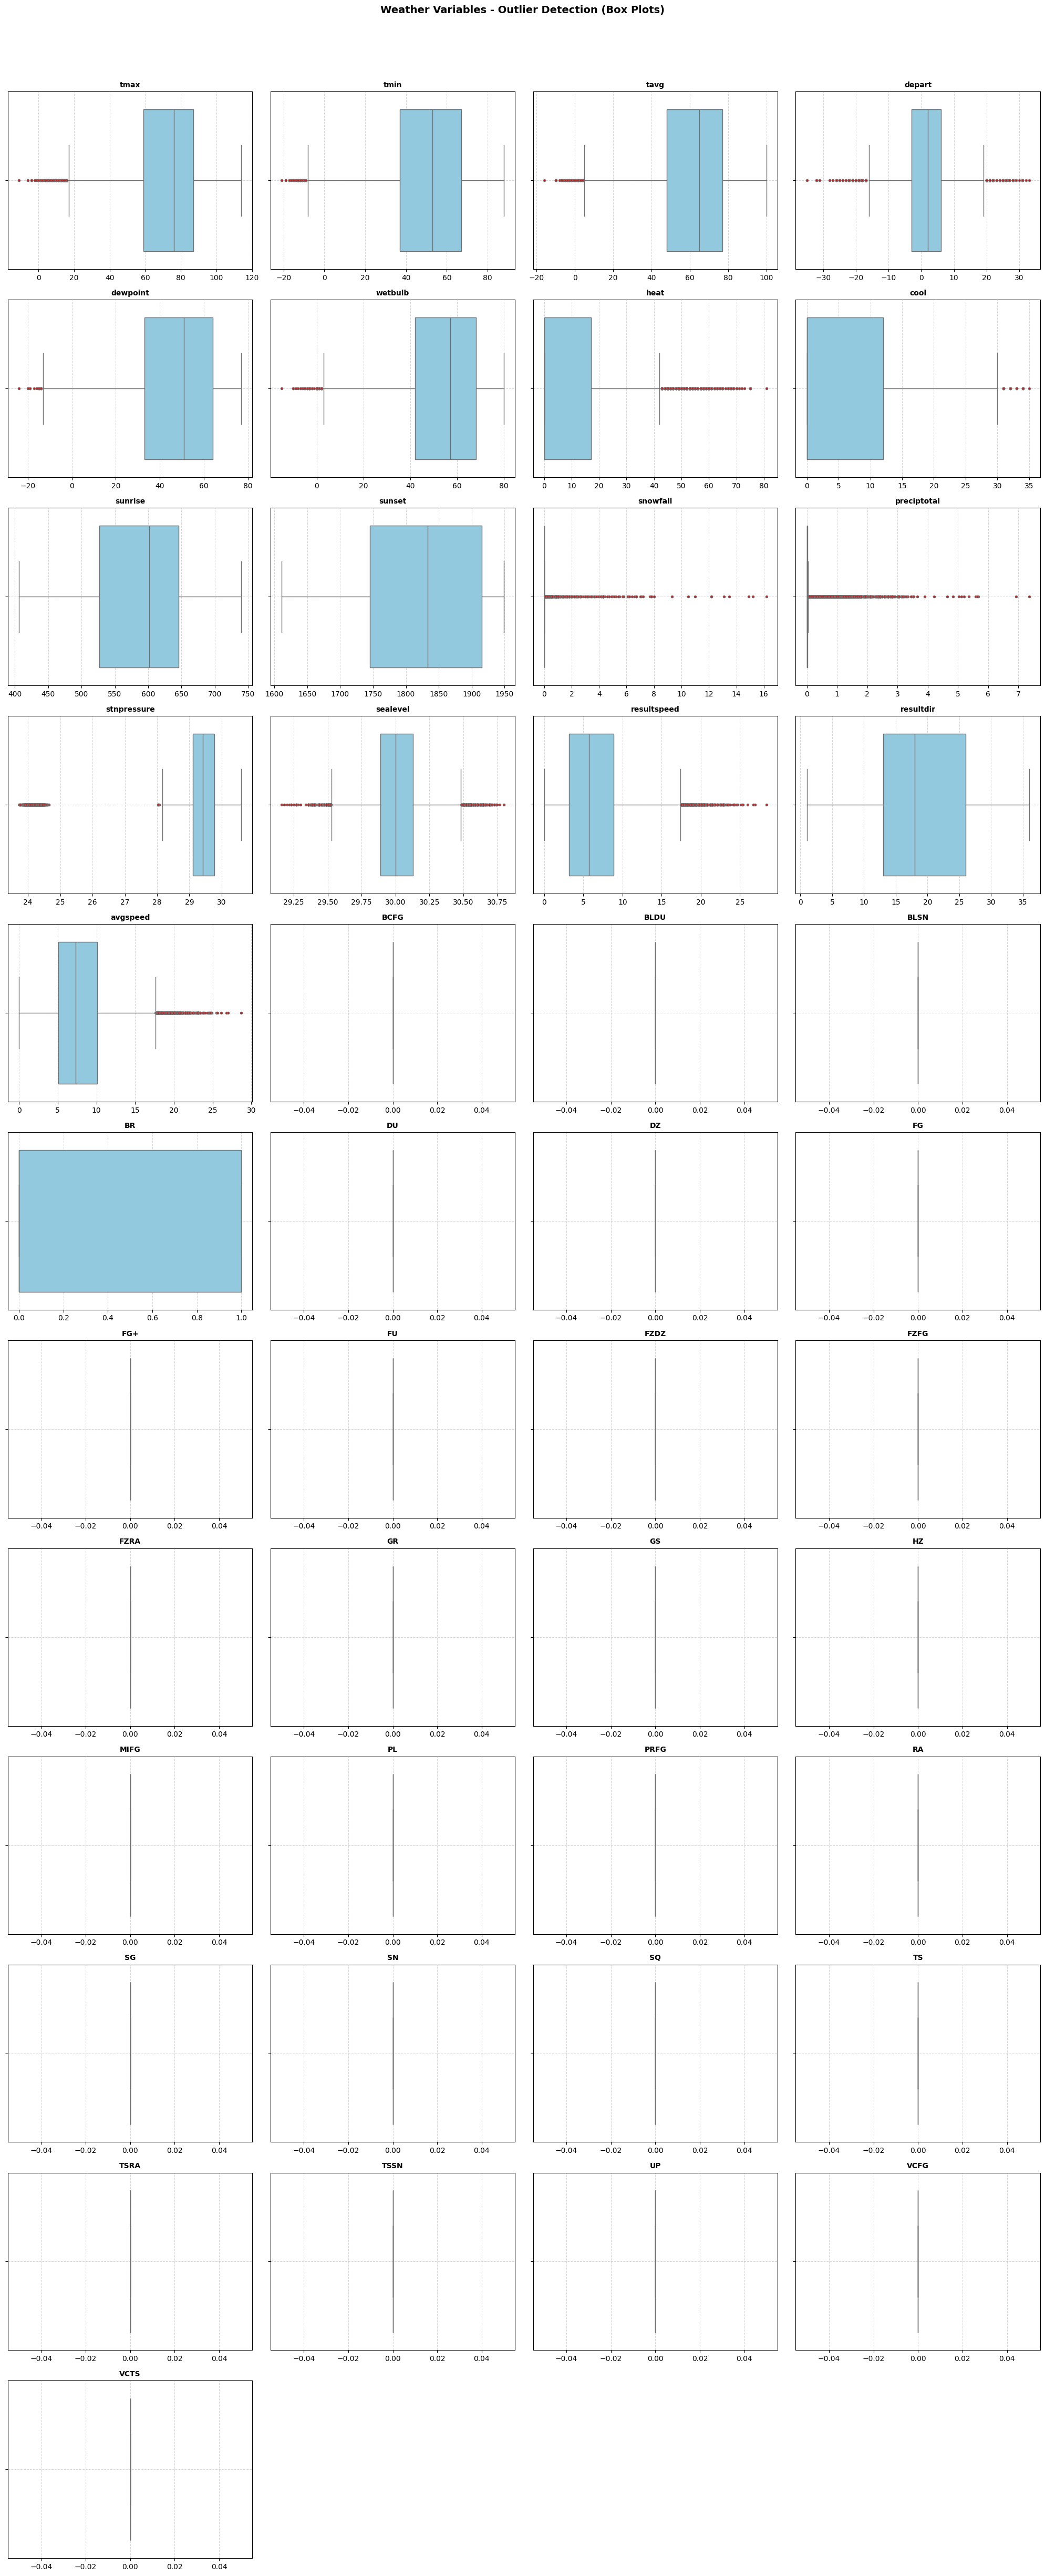

In [376]:
exclude_cols = ['station_nbr', 'date']
weather_cols = [col for col in df_weather_processed.columns if col not in exclude_cols]

plot_weather_boxplots(df_weather_processed, weather_cols, ncols=4)

In [ ]:
exclude_cols = ['station_nbr', 'date']
weather_cols = [col for col in df_weather_processed.columns if col not in exclude_cols]

#  Fill NaN theo từng trạm (Groupby Station -> Calculate Mean -> Fill)
# Dùng lambda x: x.fillna(x.mean()) để fill mean CỦA NHÓM ĐÓ vào chỗ trống CỦA NHÓM ĐÓ
df_weather_processed[weather_cols] = df_weather_processed.groupby("station_nbr")[weather_cols].transform(lambda x: x.fillna(x.mean()))

# Kiểm tra lại
print("Remaining NaN values:", df_weather_processed[weather_cols].isna().sum().sum())
print(df_weather_processed.shape)

Remaining NaN values: 19482
(20517, 47)


We fill the remaining missing weather values with the global column mean because some stations never report certain variables (for example, the sensor is not installed or has failed consistently). This second-stage imputation complements the station-level mean filling, avoids leaving whole features missing for specific stations, and keeps the imputed values within a realistic range based on the overall network distribution.

In [ ]:
df_weather_processed[weather_cols] = df_weather_processed[weather_cols].fillna(df_weather_processed[weather_cols].mean())

In [ ]:
print("Remaining NaN values:", df_weather_processed[weather_cols].isna().sum().sum())
print(df_weather_processed.shape)

Remaining NaN values: 0
(20517, 47)


## Merged Data

Merging weather data with key data using inner join

In [ ]:
df_weather_key_merged = pd.merge(df_weather_processed, df_key, how='inner', on=['station_nbr'])

Merging weather_key dataset with train data using inner join

In [ ]:
weather_key_store_merged = pd.merge(df_sales_corrected, df_weather_key_merged, how='inner', on=['store_nbr','date'])
weather_key_store_merged.shape

(236038, 51)

In [ ]:
print(check_missing_values(weather_key_store_merged).to_string()) 

             counts  ratio (%)
date              0        0.0
store_nbr         0        0.0
item_nbr          0        0.0
units             0        0.0
logunits          0        0.0
station_nbr       0        0.0
tmax              0        0.0
tmin              0        0.0
tavg              0        0.0
depart            0        0.0
dewpoint          0        0.0
wetbulb           0        0.0
heat              0        0.0
cool              0        0.0
sunrise           0        0.0
sunset            0        0.0
snowfall          0        0.0
preciptotal       0        0.0
stnpressure       0        0.0
sealevel          0        0.0
resultspeed       0        0.0
resultdir         0        0.0
avgspeed          0        0.0
BCFG              0        0.0
BLDU              0        0.0
BLSN              0        0.0
BR                0        0.0
DU                0        0.0
DZ                0        0.0
FG                0        0.0
FG+               0        0.0
FU      

## Save preprocessed data

In [ ]:
# Saving sales data
sales_data_path = os.path.join(DATA_DIR, "sales_data_preprocessed.csv")
print(f"Saving sales data to :{sales_data_path}")
df_sales_corrected.to_csv(sales_data_path, index=False)

# Saving weather data
weather_data_path = os.path.join(DATA_DIR, "weather_preprocessed.csv")
print(f"Saving weather data to :{weather_data_path}")
df_weather_key_merged.to_csv(weather_data_path, index=False)

# saving merged weather - key - sales data
weather_key_store_merged_data_path = os.path.join(DATA_DIR, "weather_key_store_merged.csv")
print(f"Saving weather data to :{weather_key_store_merged_data_path}")
weather_key_store_merged.to_csv(weather_key_store_merged_data_path, index=False)

Saving sales data to :../../data/sales_data_preprocessed.csv
Saving weather data to :../../data/weather_preprocessed.csv
Saving weather data to :../../data/weather_key_store_merged.csv
